In [1]:
import pandas as pd
import numpy as np
import string as s
import seaborn as sns
import math
# import tables
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style, colors
from itertools import groupby
import matplotlib.patches as patches
from matplotlib import gridspec
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata, leaves_list
from scipy.spatial.distance import pdist
from scipy.ndimage.interpolation import shift
# matplotlib.style.use('ggplot')
# %matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
# matplotlib.rcParams['figure.facecolor'] = 'white'
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll
matplotlib.style.use('ggplot')
%matplotlib inline



In [2]:
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/'

get meta data about library ids, hiv status, histology, total reads sequenced etc

In [5]:
nt = '{}numeric_track.txt'.format(wkdir)
ntdf = pd.read_csv(nt)
ntdf.head(2)

,patient,log_strelka_mutations
0,HTMCP-03-06-02007,6.47104
1,HTMCP-03-06-02026,6.09768


In [6]:
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/'
ct = '{}category_track.txt'.format(wkdir)
ctdf = pd.read_csv(ct)
ctdf.head(2)

,patient,HIV_status,Putative_histology,HPV_status,Remodeller,Reader,Writer,Eraser,SWI/SNF remodeling complex,SWI/SNF family,...,ISWI chromatin remdelling,HAT complexes,NuRD complex,compass complex,HDAC complex,GNAT family HAT complexes,MYST family HAT complexes,RNF20/40 complex,SWI/SNF remodeling complex,TFIID basal transcription factor complex or PCAF histone acetylase complex
0,HTMCP-03-06-02007,Negative,Adeno,Negative,Positive,Positive,Positive,Positive,Positive,Positive,...,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive
1,HTMCP-03-06-02026,Negative,Adeno,Negative,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Positive,Positive,Positive,Positive,Positive,Positive,Negative,Negative,Positive


In [7]:
def map_features_to_colors(df_track, map_dict1, clrs):
#     clrs = ["purple", "#E69F00","#009E73","#56B4E9"]#,"#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]
#     map_dict1 =  {'Adeno': 0.15,'Squamous': 0.25, 'Negative': 0.35, 'Positive': 0.45}
    map_dict2 = {}
    for n, k in enumerate(map_dict1.keys()):
        map_dict2[k] = clrs[n]
    assert list(map_dict2.values()) == clrs
    ndf_track = df_track.apply(lambda x: x.map(map_dict1)).fillna(0).T
#     legends = sorted(map_dict1, key=map_dict1.get, reverse=False)
    return (ndf_track, map_dict2)

In [8]:
def plot_cluster_heatmap(numeric_track, category_track, dfm, dfaa, mark, map_dict2, of): # df= tracks, dfm = histone mark signal df
#     df = ncategory_track.copy() # track df
    # dfm: histone mark signal df
    
    fig = plt.figure(figsize=(10, 16), facecolor='white')
    gs = gridspec.GridSpec(1, 2, width_ratios=[17,1], 
                           wspace=0.05, # horizontal space
                           hspace=0.0  # vertical space
                          )

    bounds = np.arange(0.05, len(map_dict1)/10.0 + 0.1 , 0.1).tolist()
    assert len(bounds) == len(map_dict1) + 1
    # make a color map of fixed colors
    cmap = colors.ListedColormap(clrs)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    nrow = len(category_track.index)
    ncol = len(category_track.columns)
    print('category track shape: rows={0}, cols={1}'.format(nrow, ncol))

    # left panel 3x1 for n_track, c_trak, and dendrogram
    gs01 = gridspec.GridSpecFromSubplotSpec(4, 1,  height_ratios=[.5, 14, 4, 36], subplot_spec=gs[0],  hspace=0.0)
    
     # add dendrogram
    ax1_3 = fig.add_subplot(gs01[2])
    ax1_3.set_title("")
#     ax1_3 = fig.add_subplot(gs[4], facecolor='white')
    matrix = dfm.values.T
    dist='correlation'
    link='ward'
    
    Z = linkage(pdist(matrix, dist), link)
    aa = dendrogram(Z, leaf_rotation=90.,labels = dfm.columns,leaf_font_size=12.,show_contracted=True)#
    den_labels = aa['ivl']
    adf = pd.DataFrame(den_labels)
    adf.columns = ['patient']
    c_track = category_track[den_labels]
#     c_track = pd.merge(adf, category_track.T, left_on='patient', right_index=True)#.drop(0, axis=1)
#     c_track = c_track.set_index('patient')
#     c_track = c_track.T
    plt.suptitle('unsupervised_clustering_{}_bdg_area'.format(mark), fontsize=14)  
#     print(den_labels)
    
# #     add in heatmap
#     ax1_4 = fig.add_subplot(gs01[3])
#     ax1_4.set_title("")
#     ax000 = sns.heatmap(dfaa[den_labels], ax=ax1_4, cbar_ax=cbar=False)
# #     ax000.set_aspect(0.5)
    
    
    # plot category track
    ax1_2 = fig.add_subplot(gs01[1], facecolor='white')
#     ax1_2.set_title("")
#     print(c_track)
    img = ax1_2.imshow(c_track.values, interpolation='none', origin='upper', aspect='auto',
                        cmap=cmap, norm=norm)
    _ = plt.yticks(np.arange(0, nrow, 1), c_track.index, fontsize=8)
    _ = plt.xticks(np.arange(0, ncol, 1), c_track.columns, fontsize=8, rotation=90)

    _ = ax1_2.set_yticks(np.arange(-.5, nrow, 1), minor=True);
    _ = ax1_2.set_xticks(np.arange(-.5, ncol, 1), minor=True);

    # Gridlines based on minor ticks
    _ = ax1_2.grid(b=True, which='minor', color='gray', linestyle='--', linewidth=0.3)
    # hide major tick grid
    _ = ax1_2.grid(b=True, which='major', color='r', linestyle='-', linewidth=0)

    ax1_2.spines['right'].set_visible(True)
    ax1_2.spines['top'].set_visible(True)
    ax1_2.set_xticklabels('')
#     print(c_track.columns)
    

    # plot numeric track
    ax1_1 = fig.add_subplot(gs01[0], facecolor='white')
#     ax1_1.set_title("")
    numeric_track = numeric_track.set_index('patient').astype(float)
    n_track = pd.merge(adf, numeric_track, left_on='patient', right_index=True)#.drop(0, axis=1)
    n_track = n_track.set_index('patient')
    n_track = n_track.T
    nrow = len(n_track.index)
    ncol = len(n_track.columns)
    print('numeric track shape: rows={0}, cols={1}'.format(nrow, ncol))
    img1_1 = ax1_1.imshow(n_track.values, interpolation='none', origin='upper', aspect='auto', cmap='Reds')
    _ = plt.yticks(np.arange(0, nrow, 1), n_track.index, fontsize=8)
    _ = plt.xticks(np.arange(0, ncol, 1), n_track.columns, fontsize=8, rotation=90)

    _ = ax1_1.set_yticks(np.arange(-.5, nrow, 1), minor=True);
    _ = ax1_1.set_xticks(np.arange(-.5, ncol, 1), minor=True);

    # Gridlines based on minor ticks
    _ = ax1_1.grid(b=True, which='minor', color='gray', linestyle='--', linewidth=0.3)
    # hide major tick grid
    _ = ax1_1.grid(b=True, which='major', color='r', linestyle='-', linewidth=0)

    ax1_1.spines['right'].set_visible(True)
    ax1_1.spines['top'].set_visible(True)
    ax1_1.set_xticklabels('')
#     print(n_track.columns)

    

    # right panel 2x1 for lengends, colorbar and rectangles
    gs02 = gridspec.GridSpecFromSubplotSpec(3, 1,  height_ratios=[1, 1, 1], subplot_spec=gs[1])
    
    # color bar for numeric_track 
    ax2_1 = fig.add_subplot(gs02[0], facecolor='white')
    ax2_1.set_title("mutations_log10")
        
    _ = plt.colorbar(img1_1, cax=ax2_1, orientation= 'vertical', label='')#, aspect=40) 

    
    # add retangle legend for category track
    ax2_2 = fig.add_subplot(gs02[1], facecolor='white')
    ax2_2.set_title("rectangles")
        
#     ax6 = fig.add_subplot(gs[5], facecolor='white')
    # plot mutation legend
    k = 1
    for key in map_dict2:
        if key !=0: # don't plot key=0 which means no mutation
            clr = map_dict2[key]
            rect = patches.Rectangle((0,k/7), 0.3, 0.1, linewidth=0.01,edgecolor=clr,facecolor=clr)
            _ = ax2_2.text(0.35, k/7+.07, key, ha='left', va='center', fontsize=8)
            _ = ax2_2.add_patch(rect)
        k+=1
    ax2_2.get_xaxis().set_ticks([])
    ax2_2.get_yaxis().set_ticks([])

    ax2_2.set_title('')
    
#     add in heatmap
    ax2_2 = fig.add_subplot(gs02[2], facecolor='white')
    ax2_2.set_title("heatmap colorbar")

    ax1_4 = fig.add_subplot(gs01[3])
    ax1_4.set_title("")
    dfaa = dfaa.reindex(row_den_labels)
#     cmap = sns.light_palette('red', as_cmap=True)
    cmap="vlag"
#     cmap='gist_ncar_r'
#     cmap= 'Reds'
    ax000 = sns.heatmap(dfaa[den_labels], ax=ax1_4, cbar_ax=ax2_2, cmap=cmap)#, cmap=sns.light_palette("green"))

    
    # make sure columns in numeric, category, and dendrogram match
#     print(den_labels)
#     print(c_track.columns.tolist())
    assert den_labels == c_track.columns.tolist()
    assert den_labels == n_track.columns.tolist()
#     plt.tight_layout()
    


    
#     %time plt.savefig(of, bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()
    return den_labels

In [10]:
dfaa.head(2)

HTMCP-03-06-02001  HTMCP-03-06-02006  \
chr  start   end     gene                                                    
chr1 946804  950803  ENSG00000187608           1.287012           1.451399   
     1355149 1359148 ENSG00000235098           1.361463           0.996774   

                                      HTMCP-03-06-02007  HTMCP-03-06-02012  \
chr  start   end     gene                                                    
chr1 946804  950803  ENSG00000187608           1.540920           1.246665   
     1355149 1359148 ENSG00000235098           0.627878           1.052569   

                                      HTMCP-03-06-02020  HTMCP-03-06-02026  \
chr  start   end     gene                                                    
chr1 946804  950803  ENSG00000187608           1.473877           1.456055   
     1355149 1359148 ENSG00000235098           0.911251           0.635308   

                                      HTMCP-03-06-02040  HTMCP-03-06-02042  \
chr  start   end     gene                                                    
chr1 946804  950803  ENSG00000187608           1.141285           1.393180   
     1355149 1359148 ENSG00000235098           1.059668           0.775465   

                                      HTMCP-03-06-02054  HTMCP-03-06-02058  \
chr  start   end     gene                                                    
chr1 946804  950803  ENSG00000187608           1.484666           1.510069   
     1355149 1359148 ENSG00000235098           1.259779           0.259116   

                                            ...          HTMCP-03-06-02210  \
chr  start   end     gene                   ...                              
chr1 946804  950803  ENSG00000187608        ...                   1.339243   
     1355149 1359148 ENSG00000235098        ...                   1.329205   

                                      HTMCP-03-06-02214  HTMCP-03-06-02202  \
chr  start   end     gene                                                    
chr1 946804  950803  ENSG00000187608           1.412578           1.184017   
     1355149 1359148 ENSG00000235098           1.002274           0.750020   

                                      HTMCP-03-06-02182  HTMCP-03-06-02260  \
chr  start   end     gene                                                    
chr1 946804  950803  ENSG00000187608           1.138842           1.494697   
     1355149 1359148 ENSG00000235098           1.313525           1.280573   

                                      HTMCP-03-06-02266  HTMCP-03-06-02268  \
chr  start   end     gene                                                    
chr1 946804  950803  ENSG00000187608           1.201543           1.322591   
     1355149 1359148 ENSG00000235098           1.256543           0.538479   

                                      HTMCP-03-06-02320  HTMCP-03-06-02330  \
chr  start   end     gene                                                    
chr1 946804  950803  ENSG00000187608           1.310061           1.338277   
     1355149 1359148 ENSG00000235098           1.070019           1.343241   

                                      HTMCP-03-06-02332  
chr  start   end     gene                                
chr1 946804  950803  ENSG00000187608           1.239084  
     1355149 1359148 ENSG00000235098           1.292233  

[2 rows x 35 columns]

In [11]:
dfbb.head(2)

HTMCP-03-06-02001  HTMCP-03-06-02006  \
chr  start   end     gene                                                    
chr1 946804  950803  ENSG00000187608          -0.258507           0.798880   
     1355149 1359148 ENSG00000235098           1.196579          -0.043348   

                                      HTMCP-03-06-02007  HTMCP-03-06-02012  \
chr  start   end     gene                                                    
chr1 946804  950803  ENSG00000187608           1.374711          -0.518033   
     1355149 1359148 ENSG00000235098          -1.297581           0.146351   

                                      HTMCP-03-06-02020  HTMCP-03-06-02026  \
chr  start   end     gene                                                    
chr1 946804  950803  ENSG00000187608           0.943469           0.828828   
     1355149 1359148 ENSG00000235098          -0.334124          -1.272319   

                                      HTMCP-03-06-02040  HTMCP-03-06-02042  \
chr  start   end     gene                                                    
chr1 946804  950803  ENSG00000187608          -1.195867           0.424400   
     1355149 1359148 ENSG00000235098           0.170486          -0.795791   

                                      HTMCP-03-06-02054  HTMCP-03-06-02058  \
chr  start   end     gene                                                    
chr1 946804  950803  ENSG00000187608           1.012868           1.176265   
     1355149 1359148 ENSG00000235098           0.850857          -2.551356   

                                            ...          HTMCP-03-06-02210  \
chr  start   end     gene                   ...                              
chr1 946804  950803  ENSG00000187608        ...                   0.077458   
     1355149 1359148 ENSG00000235098        ...                   1.086901   

                                      HTMCP-03-06-02214  HTMCP-03-06-02202  \
chr  start   end     gene                                                    
chr1 946804  950803  ENSG00000187608           0.549174          -0.921001   
     1355149 1359148 ENSG00000235098          -0.024649          -0.882302   

                                      HTMCP-03-06-02182  HTMCP-03-06-02260  \
chr  start   end     gene                                                    
chr1 946804  950803  ENSG00000187608          -1.211585           1.077389   
     1355149 1359148 ENSG00000235098           1.033591           0.921554   

                                      HTMCP-03-06-02266  HTMCP-03-06-02268  \
chr  start   end     gene                                                    
chr1 946804  950803  ENSG00000187608          -0.808269          -0.029649   
     1355149 1359148 ENSG00000235098           0.839856          -1.601531   

                                      HTMCP-03-06-02320  HTMCP-03-06-02330  \
chr  start   end     gene                                                    
chr1 946804  950803  ENSG00000187608          -0.110248           0.071247   
     1355149 1359148 ENSG00000235098           0.205682           1.134625   

                                      HTMCP-03-06-02332  
chr  start   end     gene                                
chr1 946804  950803  ENSG00000187608          -0.566796  
     1355149 1359148 ENSG00000235098           0.961198  

[2 rows x 35 columns]

In [13]:
row_den_labels[:2]

[('chr6', 157097064, 157101063, 'ENSG00000049618'),
 ('chr1', 91485829, 91489828, 'ENSG00000122482')]

clustering mark: H3K27ac
category track shape: rows=27, cols=35
numeric track shape: rows=1, cols=35


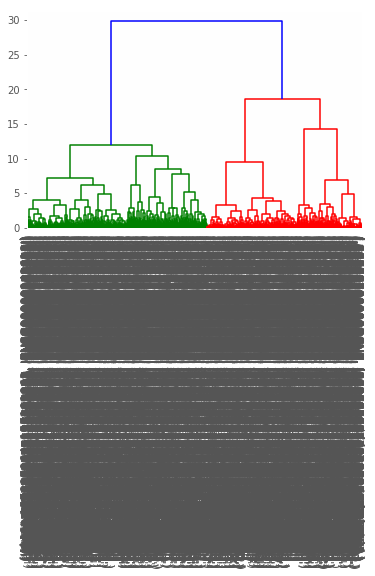

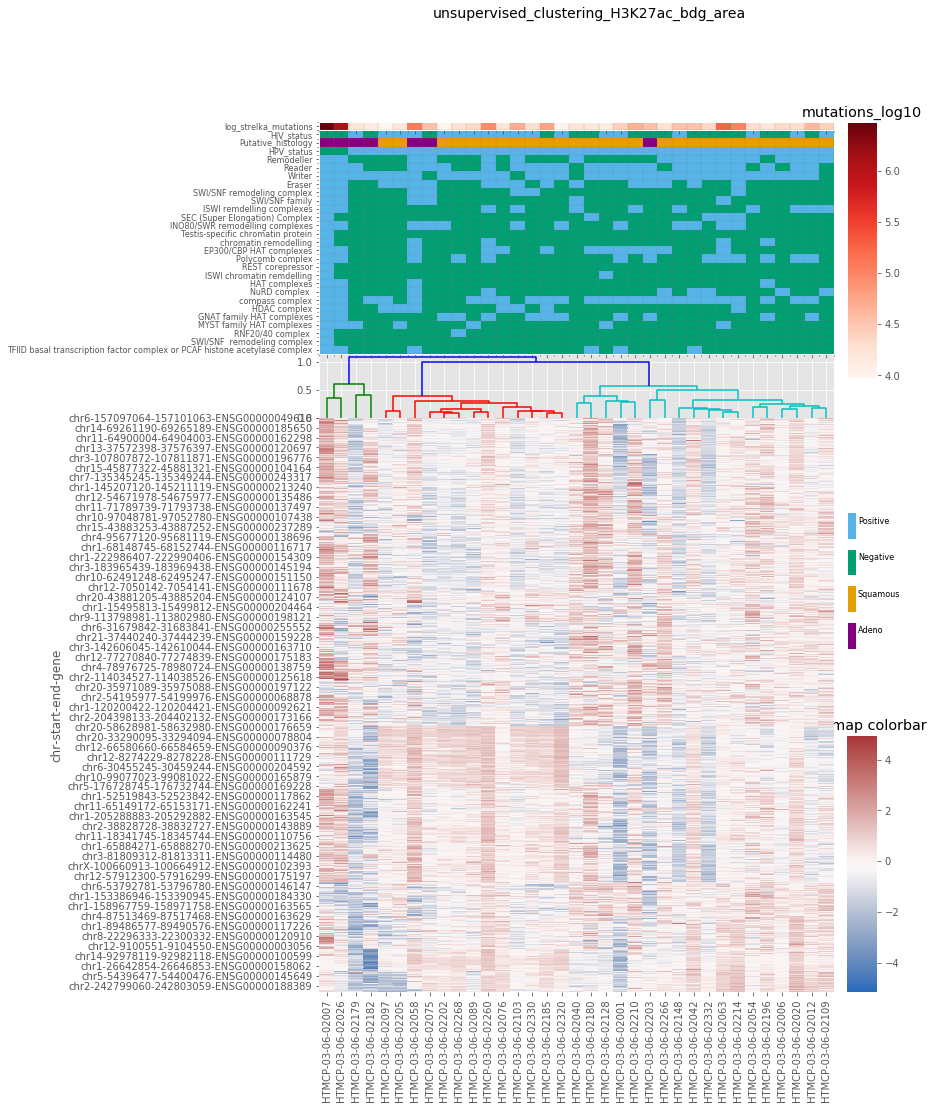

CPU times: user 1min 45s, sys: 16.5 s, total: 2min 1s
Wall time: 56.2 s


In [9]:
%%time
for mark in ['H3K27ac']:#, 'H3K4me3']:#marks[:1]:
    print('clustering mark: {}'.format(mark))
    mf = '{0}{1}_area.txt'.format(wkdir, mark)
    df_mark = pd.read_csv(mf).set_index(['chr', 'start', 'end', 'gene'])
    dfaa = df_mark.copy()

    dfaa['std'] = dfaa.std(axis=1)
    dfaa['mean'] = dfaa.mean(axis=1)
#     pick the 25% of the most variable region and mean must be in the top 3 quantile
    dfaa = dfaa[(dfaa['std']>dfaa['std'].describe()['75%'])&(dfaa['mean']>dfaa['mean'].describe()['25%'])].drop(['std', 'mean'], axis=1)
    dfaa = np.log10(dfaa + 0.001)
    # cluster on rows for visualization
    matrix = dfaa.values
    dist='correlation'
    link='ward'
    
    Z = linkage(pdist(matrix, dist), link)
    aa = dendrogram(Z, leaf_rotation=90.,labels = dfaa.T.columns,leaf_font_size=12.,show_contracted=True)#
    row_den_labels = aa['ivl']
#     dfbb is how many time deviation the point is from the mean
    dfbb = dfaa.T
    dfbb = ((dfbb - dfbb.mean())/dfbb.std()).T
#     drop 2 hypermutated cases
#     dfm_mark = dfm_mark.drop(['HTMCP-03-06-02007', 'HTMCP-03-06-02026'], axis=1)
    assert df_mark.shape[1] == 35
    cat_track = ctdf.set_index('patient')
    clrs = ["purple", "#E69F00","#009E73","#56B4E9"]#,"#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]
    map_dict1 =  {'Adeno': 0.15,'Squamous': 0.25, 'Negative': 0.35, 'Positive': 0.45}
    ncategory_track, map_dict2 = map_features_to_colors(cat_track, map_dict1, clrs)
#     print(ncategory_track.head(2))
    of = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/unsupervised_clustering_{}_bdg_area.png'.format(mark)
    den_labels = plot_cluster_heatmap(ntdf, ncategory_track, dfaa, dfbb, mark, map_dict2, of)
    

In [33]:
den_col_labels = membership
num_pats_per_cluster_list = [4, 13, 18]

In [34]:
def membership(den_col_labels, num_pats_per_cluster_list):
    # example 3 clusters: [4, 13, 18]
    clusters = []
    for k, mem in enumerate(num_pats_per_cluster_list):
        tmp = [k+1 for a in range(mem)]
        clusters+=tmp
    print(clusters)

    df_membership = pd.DataFrame({'patient':den_col_labels, 'cluster':cluster})
    df_membership.to_csv('{}H3K27ac_cluster_membership.txt'.format(wkdir), index=False, sep='\t')

In [35]:
membership(den_col_labels, num_pats_per_cluster_list)

[1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [204]:
dfaa['std'] = dfaa.std(axis=1)
dfaa['std'].describe()

count    5015.000000
mean        9.674683
std         3.198715
min         6.033878
25%         7.311935
50%         8.748659
75%        11.019046
max        35.357708
Name: std, dtype: float64

In [185]:
dfaa['std'] = dfaa.std(axis=1)
of = '{0}top_300_most_variable_{1}_marked_regions.txt'.format(wkdir, mark)

dfaa.head(2)

f21 = '/home/szong/projects/resource/gene_info_hg19.txt'
df21 = pd.read_csv(f21, sep='\t', header=None)
df21 = df21.drop([1,2], axis=1).drop_duplicates()
df21.columns = ['ENSG', 'gene_name', 'protein_coding', 'description']
df21.head()

df22 = pd.merge(dfaa.reset_index().sort_values('std', ascending=False).head(300), df21,left_on='gene', right_on='ENSG', how='left' )
df22.to_csv(of, index=False)

In [164]:
# dfaa.sort_values('std', ascending=False).head(100).to_csv(of)

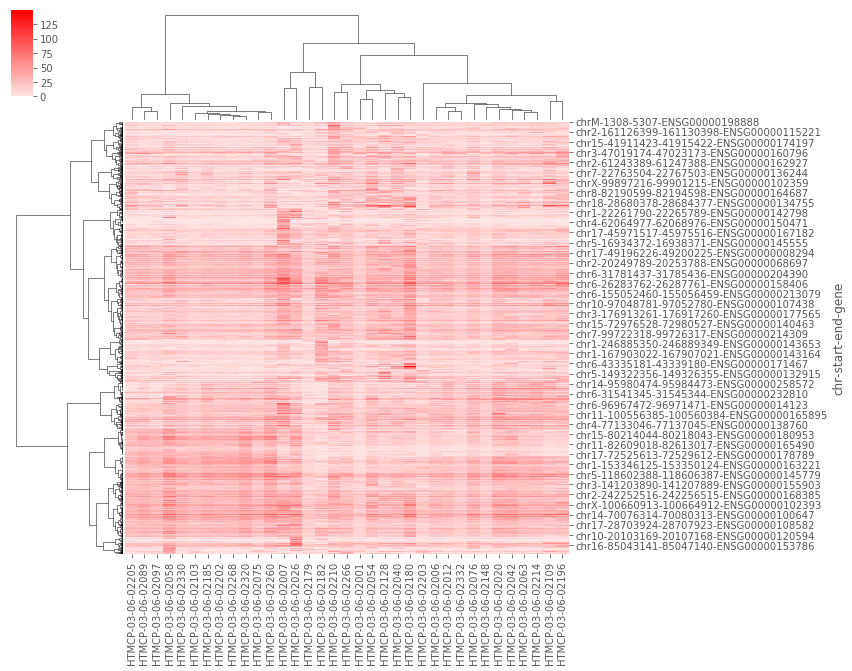

In [149]:
# seaborn cluster map: a quick look at the clustering
cmap = sns.light_palette('red', as_cmap=True)
g = sns.clustermap(dfaa, method='ward', metric='correlation',cmap = cmap)
_ = plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

# below is for clustering on chromatin states of putative TSS site

In [7]:
fs = '/projects/da_workspace/software/ChromHMM/Cervical/OUTPUT_16/states_matrix.txt'
states = pd.read_csv(fs, index_col=0)
states.head(2)

,HTMCP-03-06-02001,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02012,HTMCP-03-06-02020,HTMCP-03-06-02026,HTMCP-03-06-02040,HTMCP-03-06-02042,HTMCP-03-06-02054,HTMCP-03-06-02058,...,HTMCP-03-06-02203,HTMCP-03-06-02205,HTMCP-03-06-02210,HTMCP-03-06-02214,HTMCP-03-06-02260,HTMCP-03-06-02266,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02330,HTMCP-03-06-02332
"('chr1', 36080, 'ENSG00000237613')",11,12,12,12,12,12,12,12,11,12,...,12,13,12,12,12,12,12,12,12,11
"('chr1', 69091, 'ENSG00000186092')",12,12,12,12,12,12,12,12,12,12,...,13,12,11,12,12,11,12,12,12,12


In [8]:
# states = dfn.reset_index(drop=True).astype(int)
states['occ'] = states.T.apply(lambda x: x.nunique())
states = states[(states.occ > 2)].drop('occ', axis=1)

In [9]:
states.shape

(10826, 35)

In [21]:
def plot_cluster_heatmap(numeric_track, category_track, dfm, dfaa, mark, map_dict2, of): # df= tracks, dfm = histone mark signal df
    # this is for chromhmm plot 
    #     df = ncategory_track.copy() # track df
    # dfm: histone mark signal df
    
    fig = plt.figure(figsize=(10, 16), facecolor='white')
    gs = gridspec.GridSpec(1, 2, width_ratios=[17,1], 
                           wspace=0.05, # horizontal space
                           hspace=0.0  # vertical space
                          )

    bounds = np.arange(0.05, len(map_dict1)/10.0 + 0.1 , 0.1).tolist()
    assert len(bounds) == len(map_dict1) + 1
    # make a color map of fixed colors
    cmap = colors.ListedColormap(clrs)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    nrow = len(category_track.index)
    ncol = len(category_track.columns)
    print('category track shape: rows={0}, cols={1}'.format(nrow, ncol))

    # left panel 3x1 for n_track, c_trak, and dendrogram
    gs01 = gridspec.GridSpecFromSubplotSpec(4, 1,  height_ratios=[.5, 14, 4, 36], subplot_spec=gs[0],  hspace=0.0)
    
     # add dendrogram
    ax1_3 = fig.add_subplot(gs01[2])
    ax1_3.set_title("")
#     ax1_3 = fig.add_subplot(gs[4], facecolor='white')
    matrix = dfm.values.T
#     dist='correlation'
#     link='ward'
    dist='hamming'
    link='complete'
    Z = linkage(pdist(matrix, dist), link)
    aa = dendrogram(Z, leaf_rotation=90.,labels = dfm.columns,leaf_font_size=12.,show_contracted=True)#
    den_labels = aa['ivl']
    adf = pd.DataFrame(den_labels)
    adf.columns = ['patient']
    c_track = category_track[den_labels]
#     c_track = pd.merge(adf, category_track.T, left_on='patient', right_index=True)#.drop(0, axis=1)
#     c_track = c_track.set_index('patient')
#     c_track = c_track.T
    plt.suptitle('unsupervised_clustering_{}_bdg_area'.format(mark), fontsize=14)  
#     print(den_labels)
    
# #     add in heatmap
#     ax1_4 = fig.add_subplot(gs01[3])
#     ax1_4.set_title("")
#     ax000 = sns.heatmap(dfaa[den_labels], ax=ax1_4, cbar_ax=cbar=False)
# #     ax000.set_aspect(0.5)
    
    
    # plot category track
    ax1_2 = fig.add_subplot(gs01[1], facecolor='white')
#     ax1_2.set_title("")
#     print(c_track)
    img = ax1_2.imshow(c_track.values, interpolation='none', origin='upper', aspect='auto',
                        cmap=cmap, norm=norm)
    _ = plt.yticks(np.arange(0, nrow, 1), c_track.index, fontsize=8)
    _ = plt.xticks(np.arange(0, ncol, 1), c_track.columns, fontsize=8, rotation=90)

    _ = ax1_2.set_yticks(np.arange(-.5, nrow, 1), minor=True);
    _ = ax1_2.set_xticks(np.arange(-.5, ncol, 1), minor=True);

    # Gridlines based on minor ticks
    _ = ax1_2.grid(b=True, which='minor', color='gray', linestyle='--', linewidth=0.3)
    # hide major tick grid
    _ = ax1_2.grid(b=True, which='major', color='r', linestyle='-', linewidth=0)

    ax1_2.spines['right'].set_visible(True)
    ax1_2.spines['top'].set_visible(True)
    ax1_2.set_xticklabels('')
#     print(c_track.columns)
    

    # plot numeric track
    ax1_1 = fig.add_subplot(gs01[0], facecolor='white')
#     ax1_1.set_title("")
    numeric_track = numeric_track.set_index('patient').astype(float)
    n_track = pd.merge(adf, numeric_track, left_on='patient', right_index=True)#.drop(0, axis=1)
    n_track = n_track.set_index('patient')
    n_track = n_track.T
    nrow = len(n_track.index)
    ncol = len(n_track.columns)
    print('numeric track shape: rows={0}, cols={1}'.format(nrow, ncol))
    img1_1 = ax1_1.imshow(n_track.values, interpolation='none', origin='upper', aspect='auto', cmap='Reds')
    _ = plt.yticks(np.arange(0, nrow, 1), n_track.index, fontsize=8)
    _ = plt.xticks(np.arange(0, ncol, 1), n_track.columns, fontsize=8, rotation=90)

    _ = ax1_1.set_yticks(np.arange(-.5, nrow, 1), minor=True);
    _ = ax1_1.set_xticks(np.arange(-.5, ncol, 1), minor=True);

    # Gridlines based on minor ticks
    _ = ax1_1.grid(b=True, which='minor', color='gray', linestyle='--', linewidth=0.3)
    # hide major tick grid
    _ = ax1_1.grid(b=True, which='major', color='r', linestyle='-', linewidth=0)

    ax1_1.spines['right'].set_visible(True)
    ax1_1.spines['top'].set_visible(True)
    ax1_1.set_xticklabels('')
#     print(n_track.columns)

    

    # right panel 2x1 for lengends, colorbar and rectangles
    gs02 = gridspec.GridSpecFromSubplotSpec(3, 1,  height_ratios=[1, 1, 1], subplot_spec=gs[1])
    
    # color bar for numeric_track 
    ax2_1 = fig.add_subplot(gs02[0], facecolor='white')
    ax2_1.set_title("mutations_log10")
        
    _ = plt.colorbar(img1_1, cax=ax2_1, orientation= 'vertical', label='')#, aspect=40) 

    
    # add retangle legend for category track
    ax2_2 = fig.add_subplot(gs02[1], facecolor='white')
    ax2_2.set_title("rectangles")
        
#     ax6 = fig.add_subplot(gs[5], facecolor='white')
    # plot mutation legend
    k = 1
    for key in map_dict2:
        if key !=0: # don't plot key=0 which means no mutation
            clr = map_dict2[key]
            rect = patches.Rectangle((0,k/7), 0.3, 0.1, linewidth=0.01,edgecolor=clr,facecolor=clr)
            _ = ax2_2.text(0.35, k/7+.07, key, ha='left', va='center', fontsize=8)
            _ = ax2_2.add_patch(rect)
        k+=1
    ax2_2.get_xaxis().set_ticks([])
    ax2_2.get_yaxis().set_ticks([])

    ax2_2.set_title('')
    
#     add in heatmap
    ax2_2 = fig.add_subplot(gs02[2], facecolor='white')
    ax2_2.set_title("heatmap colorbar")

    ax1_4 = fig.add_subplot(gs01[3])
    ax1_4.set_title("")
    dfaa = dfaa.reindex(row_den_labels)
#     cmap = sns.light_palette('red', as_cmap=True)
    cmap=sns.color_palette("hls", 16)
#     cmap='gist_ncar_r'
#     cmap= 'Reds'
    ax000 = sns.heatmap(dfaa[den_labels], ax=ax1_4, cbar_ax=ax2_2, cmap=cmap)#, cmap=sns.light_palette("green"))

    
    # make sure columns in numeric, category, and dendrogram match
#     print(den_labels)
#     print(c_track.columns.tolist())
    assert den_labels == c_track.columns.tolist()
    assert den_labels == n_track.columns.tolist()
#     plt.tight_layout()
    


    
    %time plt.savefig(of, bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

category track shape: rows=27, cols=35
numeric track shape: rows=1, cols=35
CPU times: user 3.82 s, sys: 278 ms, total: 4.09 s
Wall time: 4.15 s


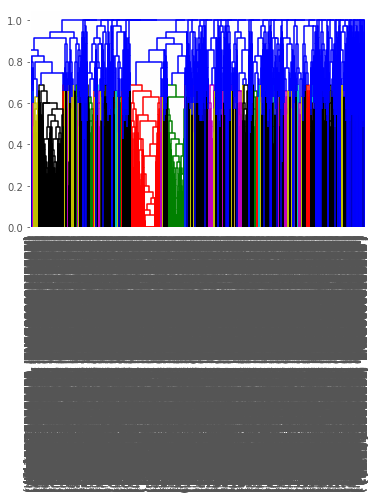

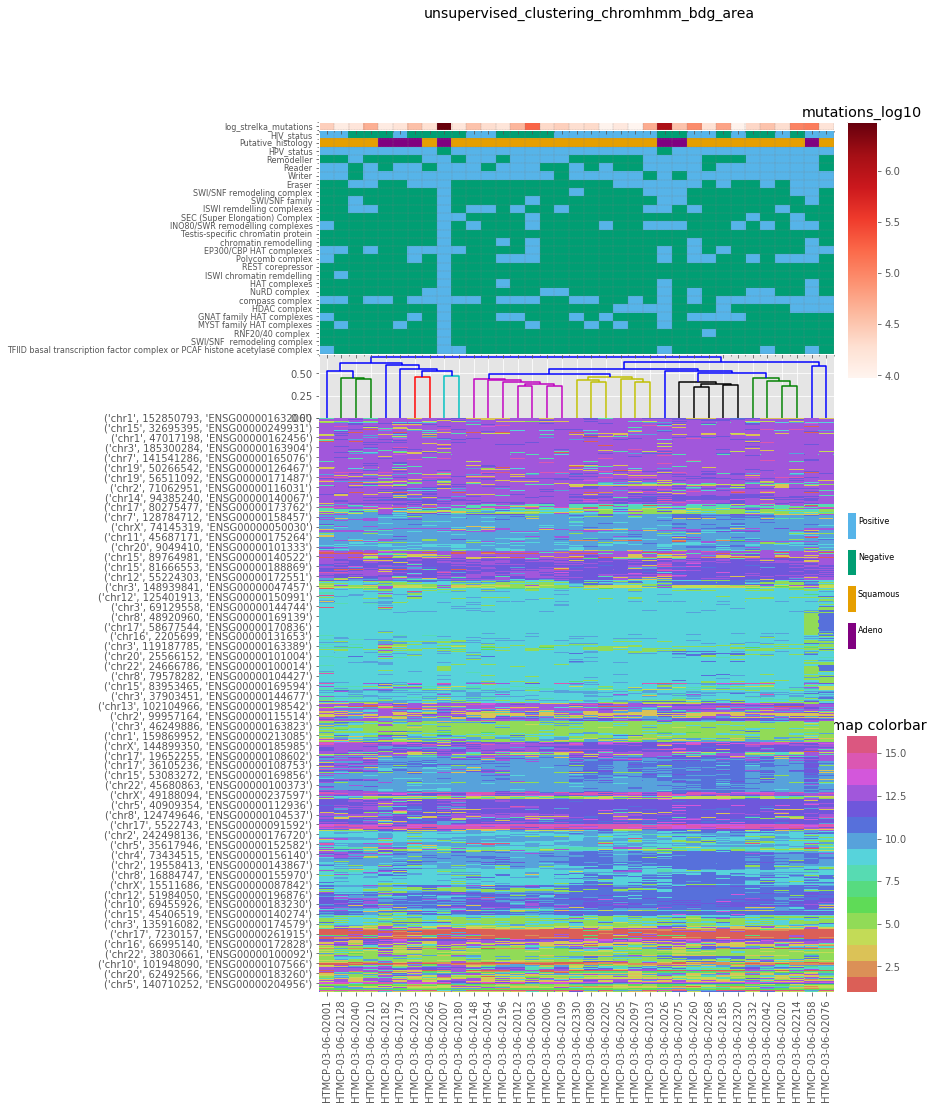

CPU times: user 1min 12s, sys: 17.2 s, total: 1min 29s
Wall time: 1min 29s


In [22]:
%%time
mark = 'chromhmm'
dfaa = states.copy()
# cluster on rows for visualization
matrix = dfaa.values
dist='hamming'
link='complete'
Z = linkage(pdist(matrix, dist), link)
aa = dendrogram(Z, leaf_rotation=90.,labels = dfaa.T.columns,leaf_font_size=12.,show_contracted=True)#
row_den_labels = aa['ivl']
#     dfbb is how many time deviation the point is from the mean
# dfbb = dfaa.T
# dfbb = ((dfbb - dfbb.mean())/dfbb.std()).T
cat_track = ctdf.set_index('patient')
clrs = ["purple", "#E69F00","#009E73","#56B4E9"]#,"#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]
map_dict1 =  {'Adeno': 0.15,'Squamous': 0.25, 'Negative': 0.35, 'Positive': 0.45}
ncategory_track, map_dict2 = map_features_to_colors(cat_track, map_dict1, clrs)
# #     print(ncategory_track.head(2))
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/unsupervised_clustering_{}_bdg_area.png'.format(mark)
plot_cluster_heatmap(ntdf, ncategory_track, dfaa, dfaa, mark, map_dict2, of)


# make input file for ChromHMM

In [2]:
f = '/home/szong/projects/META_2018/Master_Sample_table_14X292_Feb27_2018_sz.xls'
meta = pd.read_excel(f, sheetname='HTMCP CaCx epi')
meta.head(2)

,Order,Biospecimen ID,HIV status,Epigenome modifier mutation status,H3K4me1 library ID,H3K4me3 library ID,H3K9me3 library ID,H3K27me3 library ID,H3K36me3 library ID,H3K27ac library ID,...,H3K4me3 % aligned,H3K9me3 % aligned,H3K27me3 % aligned,H3K36me3 % aligned,H3K27ac % aligned,input DNA control % aligned,internal sample ID,pool ID,Notes,# lanes 7 PE
0,1,HTMCP-03-06-02007-01A,negative,mutated,A84624,A84625,A84626,A84627,A84628,A84629,...,98.13,93.1,97.93,98.57,98.10,96.26,NaN,IX5978,NaN,1
1,2,HTMCP-03-06-02026-01A,negative,mutated,A84645,A84646,A84647,A84648,A84649,A84650,...,97.68,93.89,97.84,98.17,97.86,95.56,NaN,IX5981,NaN,1


In [3]:
meta.columns

Index(['Order', 'Biospecimen ID', 'HIV status',
       'Epigenome modifier mutation status', 'H3K4me1 library ID',
       'H3K4me3 library ID', 'H3K9me3 library ID', 'H3K27me3 library ID',
       'H3K36me3 library ID', 'H3K27ac library ID',
       'input DNA control  library ID', ' Library construction status',
       'Sequencing status', 'H3K4me1 total reads', 'H3K4me3  total reads',
       'H3K9me3 total reads', 'H3K27me3 total reads', 'H3K36me3 total reads',
       'H3K27ac total reads', 'input DNA control  total reads',
       'H3K4me1 % aligned', 'H3K4me3  % aligned', 'H3K9me3 % aligned',
       'H3K27me3 % aligned', 'H3K36me3 % aligned', 'H3K27ac % aligned',
       'input DNA control   % aligned', 'internal sample ID', 'pool ID',
       'Notes', '# lanes 7 PE'],
      dtype='object')

In [4]:
meta.set_index('Biospecimen ID', inplace=True)

In [5]:
df = meta[['H3K4me1 library ID',
       'H3K4me3 library ID', 'H3K9me3 library ID', 'H3K27me3 library ID',
       'H3K36me3 library ID', 'H3K27ac library ID', 'input DNA control  library ID']].stack().reset_index()

In [6]:
df.head(2)

,Biospecimen ID,level_1,0
0,HTMCP-03-06-02007-01A,H3K4me1 library ID,A84624
1,HTMCP-03-06-02007-01A,H3K4me3 library ID,A84625


In [7]:
df['marks'] = df.level_1.apply(lambda x: x.replace(' library ID', ''))
df['patient'] = df['Biospecimen ID'].apply(lambda x: x.replace('-01A', ''))
df.drop('Biospecimen ID', axis=1, inplace=True)

In [8]:
df = df.drop('level_1', axis=1)

In [9]:
df.head(2)

,0,marks,patient
0,A84624,H3K4me1,HTMCP-03-06-02007
1,A84625,H3K4me3,HTMCP-03-06-02007


In [100]:
f = '/projects/da_workspace/software/ChromHMM/Cervical/libs.txt'
# df.to_csv(f, sep='\t', index=False, header=False)

In [81]:
df['treat'] = 'sorted_UCSC_' + df[0] + '_' + df['marks'] + '_treat_pileup.bdg'

In [82]:
df['control'] = 'sorted_UCSC_' + df[0] + '_' + df['marks'] + '_control_lambda.bdg'

In [83]:
df.head(2)

,0,marks,patient,treat,control
0,A84624,H3K4me1,HTMCP-03-06-02007,sorted_UCSC_A84624_H3K4me1_treat_pileup.bdg,sorted_UCSC_A84624_H3K4me1_control_lambda.bdg
1,A84625,H3K4me3,HTMCP-03-06-02007,sorted_UCSC_A84625_H3K4me3_treat_pileup.bdg,sorted_UCSC_A84625_H3K4me3_control_lambda.bdg


In [84]:
df = df.drop(0, axis=1)

In [85]:
df.head(2)

,marks,patient,treat,control
0,H3K4me1,HTMCP-03-06-02007,sorted_UCSC_A84624_H3K4me1_treat_pileup.bdg,sorted_UCSC_A84624_H3K4me1_control_lambda.bdg
1,H3K4me3,HTMCP-03-06-02007,sorted_UCSC_A84625_H3K4me3_treat_pileup.bdg,sorted_UCSC_A84625_H3K4me3_control_lambda.bdg


In [87]:
cols = ['patient', 'marks', 'treat', 'control']

In [89]:
df = df[cols]

In [90]:
# f = '/projects/da_workspace/software/ChromHMM/Cervical/bed_files.txt'
# df.to_csv(f, sep='\t', index=False, header=False)

In [11]:
df1 = df.set_index(0)

In [12]:
df1.head(2)

,marks,patient
0,,
A84624,H3K4me1,HTMCP-03-06-02007
A84625,H3K4me3,HTMCP-03-06-02007


In [13]:
# fbam = '/projects/da_workspace/software/ChromHMM/Cervical/bam_files.txt'
fbam = '/projects/da_workspace/software/ChromHMM/Cervical/bam_path_from_victoira.txt'
dfbam = pd.read_csv(fbam, sep='\t', header=None, index_col=0)
dfbam.head(2)

,1
0,
A84610,/projects/analysis/analysis30/IX5976/CC0TLANXX...
A84611,/projects/analysis/analysis30/IX5976/CC0TLANXX...


In [14]:
f = '/projects/da_workspace/software/ChromHMM/Cervical/bam_files.txt'
dfm = pd.merge(df1, dfbam, left_index=True, right_index=True).set_index('patient', drop=True)
# dfm.to_csv(f, sep='\t', header=False)

In [17]:
dfm.marks.unique()

array(['H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K36me3', 'H3K27ac',
       'input DNA control '], dtype=object)

In [21]:
f = '/projects/da_workspace/software/ChromHMM/Cervical/control_bam_files.txt'
dfm[dfm.marks == 'input DNA control '].to_csv(f, sep='\t', header=False)

In [24]:
dfm[dfm[1].isnull()]

,marks,1
patient,,


# look at acetylation level between HDAC mutants and wild type, H3K27ac unsupervised clustering groups

In [188]:
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/pileup_files/'

In [189]:
f1 = '{}H3K27ac_promoter_area_files.txt'.format(wkdir)
df1 = pd.read_csv(f1, header=None)
df1.head(2)

,0
0,sorted_UCSC_A84615_H3K27ac_treat_pileup.bdg.in...
1,sorted_UCSC_A84622_H3K27ac_treat_pileup.bdg.in...


In [190]:
f2 = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/category_track.txt'
df2 = pd.read_csv(f2)
df2.head(2)

,patient,HIV_status,Putative_histology,HPV_status,Remodeller,Reader,Writer,Eraser,SWI/SNF remodeling complex,SWI/SNF family,...,ISWI chromatin remdelling,HAT complexes,NuRD complex,compass complex,HDAC complex,GNAT family HAT complexes,MYST family HAT complexes,RNF20/40 complex,SWI/SNF remodeling complex,TFIID basal transcription factor complex or PCAF histone acetylase complex
0,HTMCP-03-06-02007,Negative,Adeno,Negative,Positive,Positive,Positive,Positive,Positive,Positive,...,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive
1,HTMCP-03-06-02026,Negative,Adeno,Negative,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Positive,Positive,Positive,Positive,Positive,Positive,Negative,Negative,Positive


In [191]:

dfm = pd.DataFrame()
for idx, f in df1.iterrows():
    f1 = '{0}{1}'.format(wkdir, f[0])
#     print(f1)
#         library = '_'.join(f['file_y'].split('_')[2:5])
    library = f1.split('_')[4]
#     print(library)
    dftmp = pd.read_csv(f1).set_index(['chr', 'start', 'end', 'gene'])
    dftmp.columns = [library]
#     break
    if dfm.empty:
        dfm = dftmp.copy()
    else:
        dfm = pd.merge(dfm, dftmp, left_index=True, right_index=True)


In [192]:
dfm.head(2)

A84615  A84622  A84629  A84636   A84643  \
chr  start end   gene                                                        
chr1 34081 38080 ENSG00000237613  19064.0  7442.0  5721.0  4400.0  11747.0   
     67092 71091 ENSG00000186092   9439.0  4015.0  6140.0  1524.0   8080.0   

                                  A84650   A84657   A84664   A84671   A84678  \
chr  start end   gene                                                          
chr1 34081 38080 ENSG00000237613  2488.0  11360.0  10673.0  17079.0  13365.0   
     67092 71091 ENSG00000186092  1211.0   4643.0   8398.0   3421.0    825.0   

                                     ...        A84790  A84797       A84804  \
chr  start end   gene                ...                                      
chr1 34081 38080 ENSG00000237613     ...        8481.0  6627.0  30261.70029   
     67092 71091 ENSG00000186092     ...       10514.0  1810.0   2628.77945   

                                       A84811  A84825       A84832  A84839  \
chr  start end   gene                                                        
chr1 34081 38080 ENSG00000237613  13708.11210  9095.0  26971.79655  8160.0   
     67092 71091 ENSG00000186092  11084.40853  5022.0  10756.97227  1120.0   

                                  A84846  A84853       A84860  
chr  start end   gene                                          
chr1 34081 38080 ENSG00000237613  4698.0  3800.0  11447.17304  
     67092 71091 ENSG00000186092  1620.0  1810.0   5144.61222  

[2 rows x 35 columns]

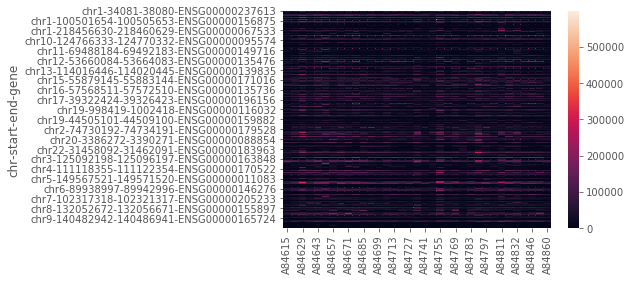

In [193]:
sns.heatmap(dfm)

In [194]:
df2[df2['HDAC complex'] == 'Positive'][['patient', 'HDAC complex', ]]

,patient,HDAC complex
0,HTMCP-03-06-02007,Positive
1,HTMCP-03-06-02026,Positive
3,HTMCP-03-06-02214,Positive
6,HTMCP-03-06-02185,Positive
17,HTMCP-03-06-02058,Positive
25,HTMCP-03-06-02097,Positive
29,HTMCP-03-06-02103,Positive
31,HTMCP-03-06-02205,Positive
34,HTMCP-03-06-02076,Positive


In [195]:
df3 = meta[['H3K27ac library ID', 'patient']].set_index('H3K27ac library ID')

NameError: name 'meta' is not defined

In [196]:
df4 = pd.merge(dfm.mean().to_frame(), df3, left_index=True, right_index=True).reset_index()

NameError: name 'df3' is not defined

In [197]:
df4.head(2)

NameError: name 'df4' is not defined

In [60]:
df5 = pd.merge(df4, df2, left_on='patient', right_on='patient')

In [61]:
df5

,index,0,patient,HIV_status,Putative_histology,HPV_status,Remodeller,Reader,Writer,Eraser,...,ISWI chromatin remdelling,HAT complexes,NuRD complex,compass complex,HDAC complex,GNAT family HAT complexes,MYST family HAT complexes,RNF20/40 complex,SWI/SNF remodeling complex,TFIID basal transcription factor complex or PCAF histone acetylase complex
0,A84615,28958.250262,HTMCP-03-06-02001,Positive,Squamous,Positive,Negative,Positive,Positive,Negative,...,Negative,Negative,Negative,Positive,Negative,Positive,Negative,Negative,Negative,Positive
1,A84622,37955.755920,HTMCP-03-06-02006,Negative,Squamous,Positive,Positive,Negative,Positive,Negative,...,Negative,Negative,Positive,Negative,Negative,Negative,Negative,Negative,Negative,Negative
2,A84629,58174.432026,HTMCP-03-06-02007,Negative,Adeno,Negative,Positive,Positive,Positive,Positive,...,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive
3,A84636,39213.776061,HTMCP-03-06-02012,Negative,Squamous,Positive,Positive,Positive,Positive,Negative,...,Negative,Negative,Negative,Positive,Negative,Positive,Negative,Negative,Negative,Negative
4,A84643,52004.792612,HTMCP-03-06-02020,Positive,Squamous,Positive,Positive,Positive,Positive,Negative,...,Negative,Negative,Negative,Positive,Negative,Negative,Negative,Negative,Negative,Negative
5,A84650,50371.768483,HTMCP-03-06-02026,Negative,Adeno,Negative,Positive,Positive,Positive,Positive,...,Negative,Positive,Positive,Positive,Positive,Positive,Positive,Negative,Negative,Positive
6,A84657,44689.170597,HTMCP-03-06-02040,Negative,Squamous,Positive,Positive,Negative,Negative,Positive,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative
7,A84664,47187.691859,HTMCP-03-06-02042,Negative,Squamous,Positive,Positive,Positive,Positive,Positive,...,Negative,Negative,Positive,Positive,Negative,Negative,Negative,Negative,Negative,Positive
8,A84671,45415.652076,HTMCP-03-06-02054,Positive,Squamous,Positive,Positive,Negative,Positive,Negative,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative
9,A84678,46467.788773,HTMCP-03-06-02058,Positive,Adeno,Positive,Positive,Positive,Positive,Positive,...,Negative,Positive,Positive,Positive,Positive,Negative,Negative,Negative,Negative,Positive


In [63]:
labels = df5.columns.tolist()
labels[0] = 'library'
labels[1] = 'area'
labels

['library',
 'area',
 'patient',
 'HIV_status',
 'Putative_histology',
 'HPV_status',
 'Remodeller',
 'Reader',
 'Writer',
 'Eraser',
 'SWI/SNF remodeling complex',
 'SWI/SNF family',
 'ISWI remdelling complexes',
 'SEC (Super Elongation) Complex',
 'INO80/SWR remodelling complexes',
 'Testis-specific chromatin protein',
 'chromatin remodelling',
 'EP300/CBP HAT complexes',
 'Polycomb complex',
 'REST corepressor',
 'ISWI chromatin remdelling',
 'HAT complexes',
 'NuRD complex\xa0',
 'compass complex',
 'HDAC complex',
 'GNAT family HAT complexes',
 'MYST family HAT complexes',
 'RNF20/40 complex\xa0',
 'SWI/SNF  remodeling complex',
 'TFIID basal transcription factor complex or PCAF histone acetylase complex']

In [64]:
df5.columns = labels

In [66]:
f5 = '{}category_track_wit_libid.txt'.format(wkdir)
# df5.to_csv(f5, index=False)

In [187]:
df6 = df5[['patient', 'area', 'HDAC complex']]

NameError: name 'df5' is not defined

observation: no difference in terms of acetylation level, the top 2 HDAC dots are 2007/2026 hypermutated cases. make sense since we have >10 genes in HDAC super family, HDAC1 and HADA2 are functionally redundant, so no patients are mutated in all these genes. parellel pathways

In [186]:
with plt.style.context("seaborn-white"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    fig = plt.figure(facecolor='white', figsize=(6,6))
    ax = sns.boxplot('HDAC complex', 'area', data=df6)
    for mybox in ax.artists:
        mybox.set_facecolor('white')
        mybox.set_edgecolor('black')
#     mybox.set_linewidth(3)
    sns.swarmplot('HDAC complex', 'area', data=df6)
    sns.despine(bottom=True, left=True)
    of = '{}HDAC_mutant_vs_WT_area.png'.format(wkdir)
    plt.savefig(of, bbox_inches='tight', dpi=200)

NameError: name 'df6' is not defined

In [77]:
df6.sort_values('area')

,patient,area,HDAC complex
19,HTMCP-03-06-02179,27794.368912,Negative
0,HTMCP-03-06-02001,28958.250262,Negative
18,HTMCP-03-06-02148,29120.059873,Negative
34,HTMCP-03-06-02332,29650.263705,Negative
23,HTMCP-03-06-02203,31272.001070,Negative
16,HTMCP-03-06-02103,32726.395085,Positive
12,HTMCP-03-06-02075,33552.819831,Negative
15,HTMCP-03-06-02097,34904.820280,Positive
31,HTMCP-03-06-02268,36480.872925,Negative
21,HTMCP-03-06-02185,37092.665736,Positive


In [39]:
df = pd.DataFrame({'a':[3, 6], 'b':[8, 10]})

In [40]:
df

,a,b
0,3,8
1,6,10


In [41]:
df['x'] = df.a + 5